In [2]:
import uproot as up
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('seaborn-v0_8-paper')
plt.rcParams["patch.force_edgecolor"] = True

In [23]:
all_feature_df = pd.read_csv("../../../../mnt/fcufino/all_features_IBD_He.csv")
all_feature = {col: all_feature_df[col].values for col in all_feature_df.columns}



features_BKG_df = all_feature_df[all_feature_df['Label'] == 0] #Qui c'è sia IBD_fake che BKG_radioactive
features_BKG = {col: features_BKG_df[col].values for col in features_BKG_df.columns}

features_IBD_df = all_feature_df[all_feature_df['Label'] == 1] #Label = 1 sono i VERI ibd
features_IBD = {col: features_IBD_df[col].values for col in features_IBD_df.columns}


# Cutting algorithm for BOTH IBD and BKG

In [24]:
from numba import njit, prange

In [25]:
@njit(parallel = True) 
#delta time in nanoseconds
#delta radius in mm
def selection(dt,dr,E_pro,E_del, delta_time = 1e6, delta_radius = 1500, min_energy_prompt = 0.7,max_energy_prompt = 12, min_energy_delay = 1.9, max_energy_delay = 2.5, min_energy_delay_carb = 4.4, max_energy_delay_carb = 5.5):
    prompt_columns = np.zeros(dt.shape)
    delay_columns = np.zeros(dt.shape)
    delay_columns_carb = np.zeros(dt.shape)
    for i in prange(dt.shape[0]):
        if dt[i] < delta_time: 
            if dr[i] < delta_radius: 
                if E_pro[i]>= min_energy_prompt and E_pro[i]<= max_energy_prompt:
                    if E_del[i]>= min_energy_delay and E_del[i]<= max_energy_delay:
                        prompt_columns[i] = 1
                        delay_columns[i] = 1
                    if E_del[i]>= min_energy_delay_carb and E_del[i]<= max_energy_delay_carb:
                        prompt_columns[i] = 1
                        delay_columns_carb[i] = 1
    return prompt_columns,delay_columns,delay_columns_carb

### IBD selection, searching for true IBD events

In [26]:
prompt_columns_IBD, delay_columns_IBD, delay_columns_carb_IBD = selection(features_IBD["delta_time"],
                                                                           features_IBD["delta_radius"],
                                                                           features_IBD["E_pro"],
                                                                           features_IBD["E_del"])

In [27]:
print("Venongono selezionati come IBD ", prompt_columns_IBD.sum(),"Su un tot di", prompt_columns_IBD.shape[0])


TP = np.logical_and(features_IBD['Label'] == 1, prompt_columns_IBD == 1)
TN = np.logical_and(features_IBD['Label'] == 0, prompt_columns_IBD == 0)
FN = np.logical_and(features_IBD["Label"] == 1, prompt_columns_IBD == 0)
FP = np.logical_and(features_IBD["Label"] == 0, prompt_columns_IBD == 1) 

print("Efficiency: ", (TP.sum()/(TP.sum()+FN.sum())) * 100)
#Efficiency sono il numero di eventi IBD veri selezionati diviso il numero totale di IBD.
print("Purity: ", (TP.sum()/(TP.sum()+FP.sum())) * 100)	

Venongono selezionati come IBD  1435115.0 Su un tot di 1468385
Efficiency:  97.73424544652799
Purity:  100.0


### BKG selection, searching for fake IBD eventi in BKG_RADIOACTIVITY dataset

In [28]:
prompt_columns_BKG, delay_columns_BKG, delay_columns_carb_BKG = selection(features_BKG["delta_time"][features_BKG["Source"] == 0],
                                                                           features_BKG["delta_radius"][features_BKG["Source"] == 0],
                                                                           features_BKG["E_pro"][features_BKG["Source"] == 0],
                                                                           features_BKG["E_del"][features_BKG["Source"] == 0])

In [29]:
print(prompt_columns_BKG.sum(), prompt_columns_BKG.shape[0])

TP = np.logical_and(features_BKG['Label'][features_BKG["Source"] == 0] == 0, prompt_columns_BKG == 0)
TN = np.logical_and(features_BKG['Label'][features_BKG["Source"] == 0] == 1, prompt_columns_BKG == 1)
FN = np.logical_and(features_BKG["Label"][features_BKG["Source"] == 0] == 0, prompt_columns_BKG == 1)
FP = np.logical_and(features_BKG["Label"][features_BKG["Source"] == 0] == 1, prompt_columns_BKG == 0) 

print("Efficiency: ", (TP.sum()/(TP.sum()+FN.sum())) * 100)
print("Purity: ", (TP.sum()/(TP.sum()+FP.sum())) * 100)	

43683.0 44916
Efficiency:  2.745124231899546
Purity:  100.0


# TOTAL Cut Algorithm 

In [12]:
prompt_columns, delay_columns, delay_columns_carb = selection(all_feature["delta_time"],
                                                              all_feature["delta_radius"],
                                                              all_feature["E_pro"],
                                                              all_feature["E_del"])

In [13]:
TP = np.logical_and(all_feature['Label'] == 1, prompt_columns == 1)
TN = np.logical_and(all_feature['Label'] == 0, prompt_columns == 0)
FN = np.logical_and(all_feature["Label"] == 1, prompt_columns == 0)
FP = np.logical_and(all_feature["Label"] == 0, prompt_columns == 1) 

print("Efficiency: ", (TP.sum()/(TP.sum()+FN.sum())) * 100)
print("Purity: ", (TP.sum()/(TP.sum()+FP.sum())) * 100)	

Efficiency:  97.73424544652799
Purity:  97.04532498787876


# Plots

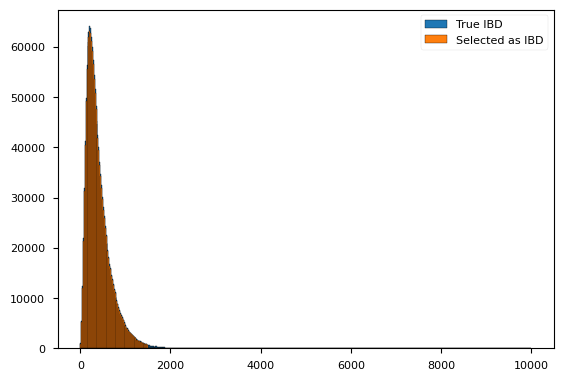

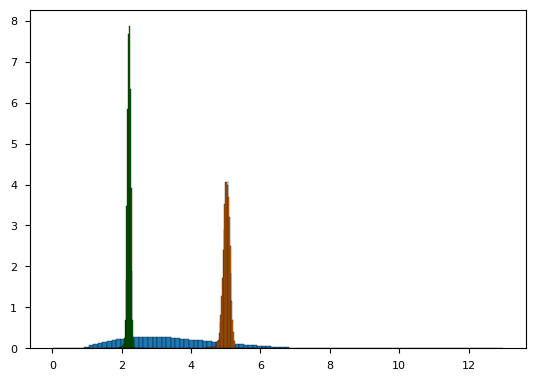

In [14]:
fig2 = plt.figure()
plt.hist(features_IBD["delta_radius"][features_IBD['Label'] == 1], np.linspace(0, 1e4, 500));
plt.hist(features_IBD["delta_radius"][prompt_columns_IBD == 1], np.linspace(0, 1e4, 500));
plt.legend(["True IBD","Selected as IBD"]);

fig3 = plt.figure()
plt.hist(features_IBD["E_pro"][prompt_columns_IBD == 1], np.linspace(0,13,100), density = True);
plt.hist(features_IBD["E_del"][delay_columns_IBD == 1], np.linspace(1.5,2.7,50), color= "green", density = True);
plt.hist(features_IBD["E_del"][delay_columns_carb_IBD == 1], np.linspace(4.4,5.5,50), density=True);